<a href="https://colab.research.google.com/github/Git-Hub-Pro/business_card_recognition/blob/master/business_card_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
# Install pytesseract and tesseract-OCR in google colab.
# pytesseract 은 글자 인식을 해주는 오픈 소스이다.
# 참고 : https://medium.com/@bhadreshpsavani/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

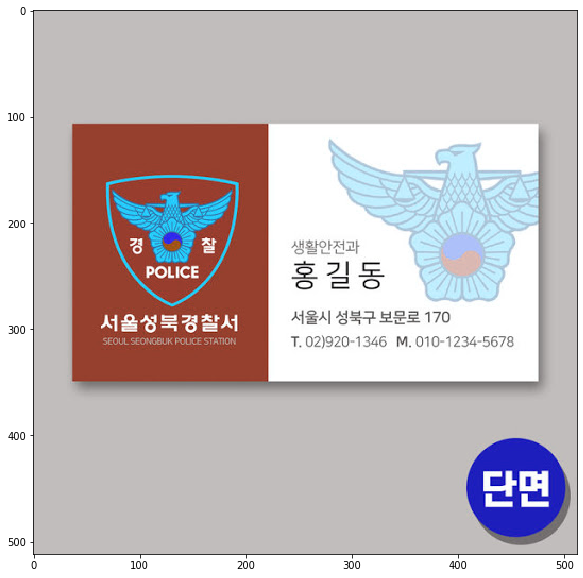

In [0]:
# Read Input Image
img_ori = cv2.imread("/content/gdrive/My Drive/data/bcimg1.jpg")

height, width, channel = img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori,cmap='gray')

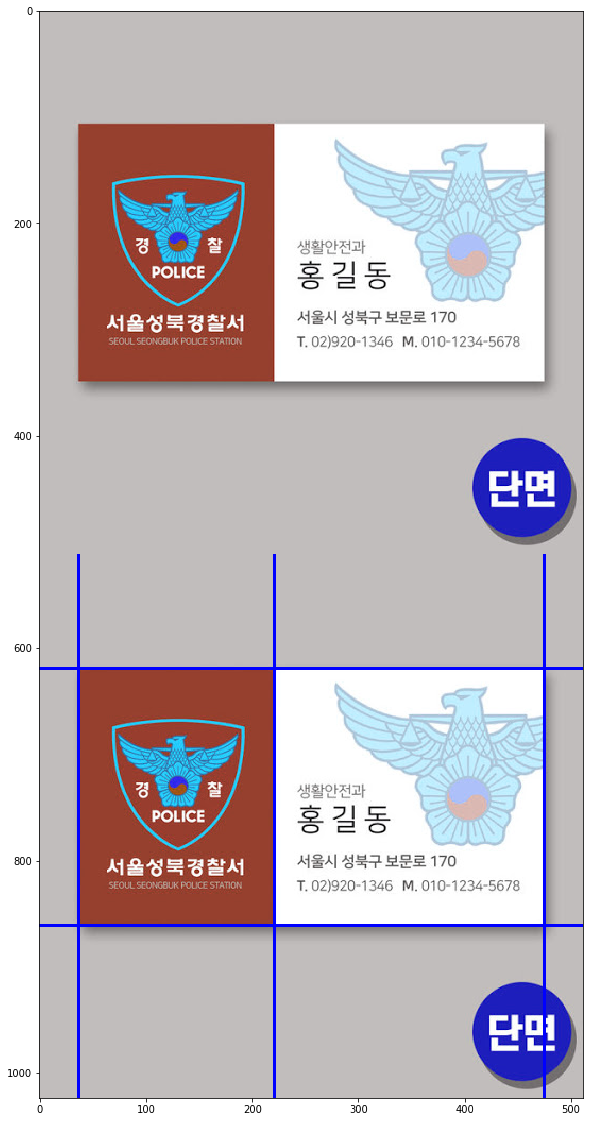

In [0]:
# 허프 변환
# 허프 변환은 이미지에서 모양을 찾는 가장 유명한 방법입니다. 이 방법을 이용하면 이미지의 형태르ㄹ 찾거나 누락되거나 깨진 영역을 복원할 수 있습니다.
# cv2.HoughLines(image,rho,theta,threshold[,lines[,srn[,stn[,min_theta[,max_theta]]]]) -> lines
# Parameters:
# image - 8bit, single-channel binary image, canny edge를 선 적용.
# rho - r 값의 범위 (0~1 실수)
# theta -세타 값의 범위(0~180 정수)
# threshold - 만나는 점의 기준, 숫자가 작으면 많은 선이 검출되지만 정확도가 떨어지고,숫자가 크면 정확도가 올라감.
img = cv2.imread("/content/gdrive/My Drive/data/bcimg1.jpg")

gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize=3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)

linesegment = []


for i in range(len(lines)):
    for rho, theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0+1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 -1000*(a))      
        linesegment.append({
            'idx':i,
            'xs':x1,
            'ys':y1,
            'xe':x2,
            'ye':y2 
        })
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

res = np.vstack((img_ori,img))

plt.figure(figsize=(12,20))
plt.imshow(res,cmap='gray')


In [0]:
def get_crosspt(x11,y11, x12,y12, x21,y21, x22,y22):
    if x12==x11 or x22==x21:
        # print('delta x=0')
        if x12==x11:
            cx = x12
            if(x22-x21 ==0): 
              return None
              
            m2 = (y22 - y21) / (x22 - x21)
            cy = m2 * (cx - x21) + y21
            return cx, cy
        if x22==x21:
            cx = x22
            m1 = (y12 - y11) / (x12 - x11)
            cy = m1 * (cx - x11) + y11
            return cx, cy

    m1 = (y12 - y11) / (x12 - x11)
    m2 = (y22 - y21) / (x22 - x21)
   
    if m1==m2:
        # print('parallel')
        return None
  
    print(x11,y11, x12, y12, x21, y21, x22, y22, m1, m2)
    cx = (x11 * m1 - y11 - x21 * m2 + y21) / (m1 - m2)
    cy = m1 * (cx - x11) + y11

    return cx, cy

In [0]:
# 교차점을 구하는 함수.(방정식을 활용)
def find_crossing_points(line_list):
    crossing_point = []
    for d1 in line_list:
        for d2 in line_list:
            if d1['idx']==d2['idx']:
                continue
            if(get_crosspt(d1['xs'],d1['ys'], d1['xe'],d1['ye'], d2['xs'],d2['ys'],d2['xe'],d2['ye'])==None):
              continue
            x,y = get_crosspt(d1['xs'],d1['ys'], d1['xe'],d1['ye'], d2['xs'],d2['ys'],d2['xe'],d2['ye'])
            #print(x,y)
            crossing_point.append({
                'x':x,
                'y':y
            })
    
    return crossing_point

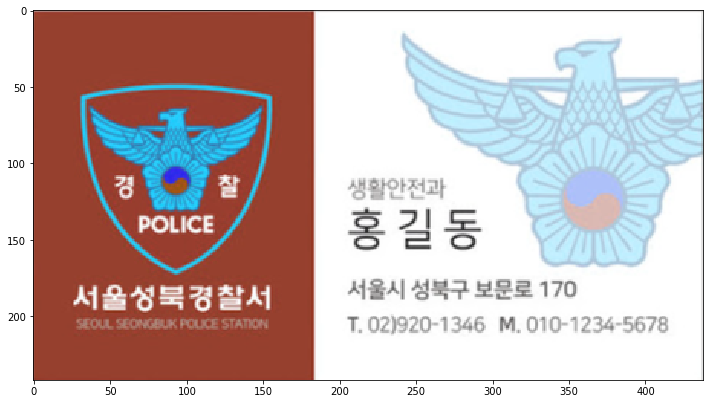

In [0]:
# 명함은 직사각형이므로 꼭짓점이 4개이다. 교차점이 4개 이상일 경우에만 인식을 시작. 
    line_list = find_crossing_points(linesegment)
    line_list = list(map(dict, set(tuple(sorted(d.items())) for d in line_list)))
    sorted_line_list = sorted(line_list,key=lambda x:(x['x'],x['y']))
    line_list_len = len(sorted_line_list)
    if line_list_len >= 4:
        card_cx = (sorted_line_list[0]['x']+sorted_line_list[1]['x']+sorted_line_list[line_list_len-2]['x']+sorted_line_list[-1]['x'])/4
        card_cy = (sorted_line_list[0]['y']+sorted_line_list[1]['y']+sorted_line_list[line_list_len-2]['y']+sorted_line_list[-1]['y'])/4
        card_width = (abs(sorted_line_list[0]['x']-sorted_line_list[line_list_len-2]['x'])+abs(sorted_line_list[1]['x']-sorted_line_list[-1]['x']))/2
        card_height =(abs(sorted_line_list[0]['y']-sorted_line_list[1]['y'])+abs(sorted_line_list[line_list_len-2]['y']-sorted_line_list[-1]['y']))/2
        
        # 평행한 두 선을 처음과 끝을 통하여 비스듬히 되어있는 각도를 구하기(밑변과 대각선의 길이를 바탕으로)
        triangle_height = abs(sorted_line_list[1]['y']-sorted_line_list[-1]['y'])
        triangle_hypotenus = np.linalg.norm(np.array([sorted_line_list[1]['x'],sorted_line_list[1]['y']])-np.array([sorted_line_list[-1]['x'],sorted_line_list[-1]['y']]))
        angle = np.degrees(np.arcsin(triangle_height/triangle_hypotenus))
        rotation_matrix = cv2.getRotationMatrix2D(center=(card_cx,card_cy),angle=angle,scale=1.0)

        img_rotated = cv2.warpAffine(img_ori,M=rotation_matrix,dsize=(int(width),int(height)))

        img_cropped = cv2.getRectSubPix(img_ori,patchSize=(int(card_width),int(card_height)),center=(int(card_cx),int(card_cy)))

plt.figure(figsize=(12,10))
plt.imshow(img_cropped,cmap='gray')

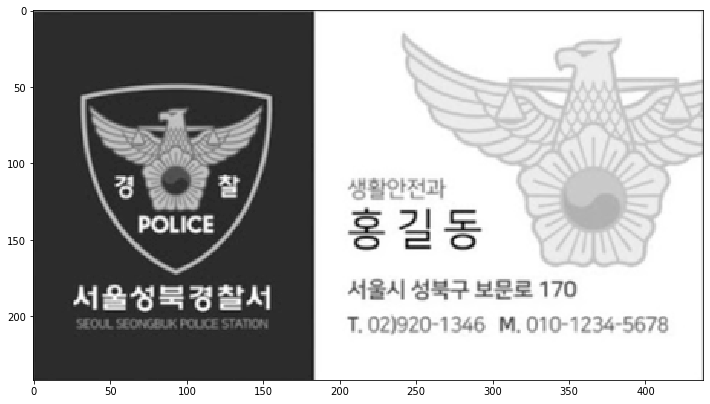

In [0]:
height, width,channel = img_cropped.shape
# Convert Image to Grayscale
gray = cv2.cvtColor(img_cropped,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray,cmap='gray')

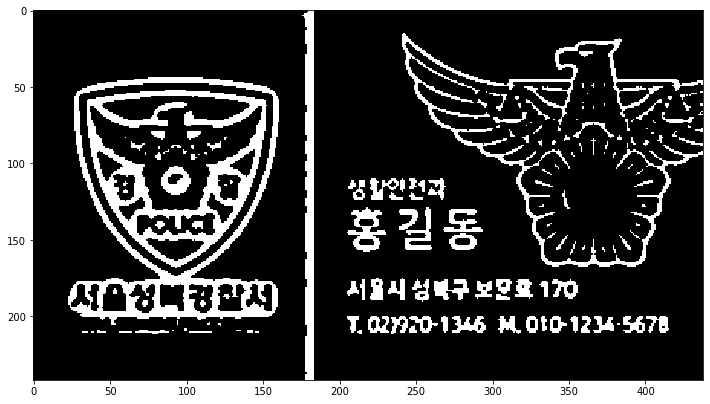

In [0]:
# Adaptive Thresholding
# 적응 임계처리
# 기본 임계처리는 임계값을 이미지 전체에 적용하여 처리하기 때문에 하나의 이미지에 음영이 다르면 일부 영역이 모두 흰색 또는 검정색으로
# 보여지게 됩니다. 이런 문제를 해결하기 위해 이미지의 작은 영역별로 thresholding을 하는 것입니다. 이때 사용하는 함수가 
# adaptiveThreshold입니다.
# cv2.adaptiveThreshold(src,maxvalue,adaptiveMethod,thresholdType,blockSize,C)
# src - grayscale image , maxValue - 최대값, adaptiveMehtod : thresholding value를 결정하는 방법,thresholdType:threshold type
# blocksize = thresholding을 적용할 영역 사이즈, C-평균이나 가중평균에서 차감할 값
# Adaptive mehod 
# cv2.ADAPTIVE_THRESH_MEAN_C : 주변 영역의 평균값으로 결정
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 정규분포의 평균.

# Image Filtering 
# 이미지도 음성 신호처럼 주파수로 표현할 수 있습니다. 일반적으로 고주파는 밝기의 변화가 많은 곳, 즉 경계선 영역에서 나타나며,
# 일반적으로 배경은 저주파로 나타납니다. 이것을 바탕으로 고주파를 제거하면 Blur 처리가 되며, 저주파를 제거하면 대상의 영역을 확인할 수 있습니다.
# cv.blur(src,ksize) 
# Gaussian Filtering (Gaussian 함수를 이용한 kernel을 적용합니다.)
# kernel 사이즈는 양수이면서 홀수로 지정을 해야 합니다. 이미지의 Gaussian Noise(전체적으로 밀도가 동일한 노이즈, 백색노이즈)를 제거하는 데 효과적입ㄴㅣ다.
# cv2.GaussianBlur(img,ksize,sigmaX)
# img, ksize, sigmaX : gaussian kernel standard deviation in X direction
# 참고 사이트:https://opencv-python.readthedocs.io/en/latest/doc/11.imageSmoothing/imageSmoothing.html
img_blurred = cv2.GaussianBlur(gray,ksize=(5,5),sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12,10))
plt.imshow(img_thresh,cmap='gray')

생 활 안 전 과
홍 길 동
서 울 시 성 복 구 보 문 료 170

기 0709 논 다월 벽 이0 ) 구7 애


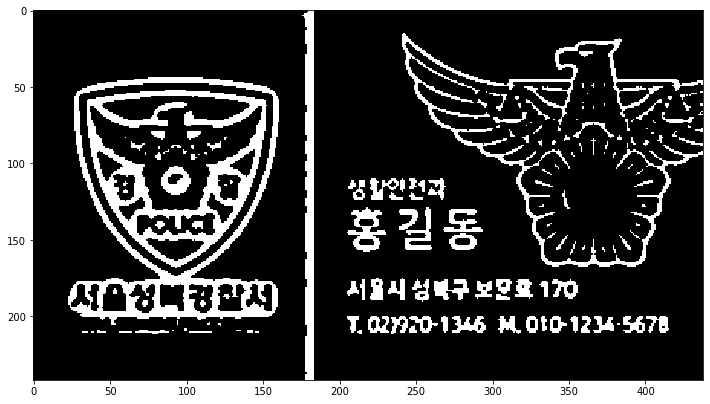

In [121]:
# 선별된 이미지를 바탕으로 pytesseract를 활용하여 문자로 변환하기
# Tesseract config은 사진 전체를 글자로 변환하고, LSTM을 적용하는 값을 설정하였다.
# 이미지로부터 텍스트를 인식하고 , 추출하는 소프트웨어를 일반적으로 OCR이라고 한다. 
# LSTM과 같은 딥러닝 방식을 통해 텍스트 인식률을 개선하고 있다
# 참고 : https://github.com/madmaze/pytesseract

# kor trainned data 추가하기
# google colab side bar에서 Files에서 경로 /usr/share/tesseract-ocr/4.00/testdata 에 traineddata 추가하기
# trained data 다운로드 : https://github.com/tesseract-ocr/tessdata/blob/master/kor.traineddata

    # chars = pytesseract.image_to_string(img_result, lang='eng', config='--psm 1 -c preserve_interword_spaces=1')
    chars = pytesseract.image_to_string(img_thresh, lang='kor', config='--psm 3 --oem 2')
    print(chars)

    plt.figure(figsize=(12,10))
    plt.imshow(img_thresh,cmap='gray')